In [87]:
import os, time
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
import numpy as np
import matplotlib.pyplot as plt

In [88]:
nPoint = 1000
X = np.linspace(0,4*np.pi, nPoint)
y = np.sin(X) + np.random.random((nPoint,))/2 + X*3/4 + np.cos(3/2*X)
X = X[..., np.newaxis]
#fig, ax = plt.subplots()
#ax.plot(X,y,'*--')

In [89]:
def model_linear(X):

    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(X)

    layerIn = Input(shape=(1,))
    layerMid = normalizer(layerIn)
    layerOut = Dense(1, kernel_initializer='normal')(layerMid)
    model = Model(inputs=layerIn, outputs=layerOut)
    return model

def model_nonLinear(X, layerShapes, activation):

    normalizer = preprocessing.Normalization(axis=-1)
    normalizer.adapt(X)

    layerIn = Input(shape=(1,))
    layerMid = normalizer(layerIn)
    for layerShape in layerShapes:
        layerMid = Dense(layerShape, activation=activation, kernel_initializer='normal')(layerMid)
        # layerMid = BatchNormalization()(layerMid)
    layerOut = Dense(1, kernel_initializer='normal')(layerMid)
    model = Model(inputs=layerIn, outputs=layerOut)
    return model

In [90]:
def get_latest_checkpoint_folder(path):
    a = os.listdir(path)
    if a:
        a.sort()
        return os.path.join(path, a[-1])
    else:
        return ''

In [91]:
def train_model(X, y, model, modelParam):

    #Check if model exist
    if not(os.path.exists(modelParam['checkpoint_dirname'])):
        os.mkdir(modelParam['checkpoint_dirname'])
        latestDir = ''
    else:
        latestDir = get_latest_checkpoint_folder(modelParam['checkpoint_dirname'])
        
    if latestDir:        
        print(f'Load model from {latestDir}')
        latestFile = tf.train.latest_checkpoint(latestDir)
        model.load_weights(latestFile)
    else:
        print('Load new model')

    if 'patience' in modelParam.keys():
        patience = modelParam['patience']
    else:
        patience = 30
        
    earlyStoppingCallback = EarlyStopping(monitor='loss', patience=patience, min_delta=0)

    checkpointFilepath = os.path.join(
                                modelParam['checkpoint_dirname'], 
                                time.strftime("%Y-%m-%d-%H-%M-%S"),
                                modelParam['checkpoint_filename'])
    checkpointCallback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpointFilepath,
        save_weights_only=True,
        monitor='loss',
        mode='min',
        save_best_only=True)

    model.compile(
        optimizer=tf.optimizers.Adam(learning_rate=modelParam['learning_rate']),
        loss='mean_absolute_error', metrics=['mean_absolute_percentage_error'])

    history = model.fit(X, y, epochs=1000, callbacks=[checkpointCallback, earlyStoppingCallback ], verbose=0)
    return history

In [92]:
def plot_loss(history):
    hist = history.history
    x_arr = np.arange(len(hist['loss'])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist['loss'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Loss', size=15)
    ax.legend(fontsize=15)

    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist['mean_absolute_percentage_error'], '-o', label='Train loss')
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('MAPE', size=15)
    ax.legend(fontsize=15)
    plt.show()

In [93]:
def plot_predict(X, y, model):
    y_pred = model(X)
    fig ,ax = plt.subplots()
    ax.plot(X,y)
    ax.plot(X,y_pred)
    plt.show()

In [137]:
cwd = os.getcwd()
modelParams = {
    'linear': {
            'model': model_linear(X),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'linear'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.1},
    'S1': {
            'model': model_nonLinear(X, [1], 'sigmoid'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S1'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.1},       
    'S2': {
            'model': model_nonLinear(X, [10], 'sigmoid'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S2'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.1},         
   'S3': {
            'model': model_nonLinear(X, [64, 64], 'sigmoid'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S3'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.1},   
   'S4': {
            'model': model_nonLinear(X, [128, 64, 10], 'sigmoid'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S4'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.01,
            'patience': 100
            }, 
   'S5': {
            'model': model_nonLinear(X, [256, 128, 64, 32, 10], 'relu'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S5'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.01,
            'patience': 200
            },   
   'S6': {
            'model': model_nonLinear(X, [256, 256, 128, 64, 32, 16], 'relu'),
            'checkpoint_dirname': os.path.join(cwd,'tmp', 'S6'),
            'checkpoint_filename':'cp-{epoch:04d}.ckpt',
            'learning_rate': 0.001,
            'patience': 300
            },  
}

In [138]:
#modelName = 'linear'
modelName = 'S6'

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
normalization_6 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_19 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_20 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_22 (Dense)             (None, 32)              

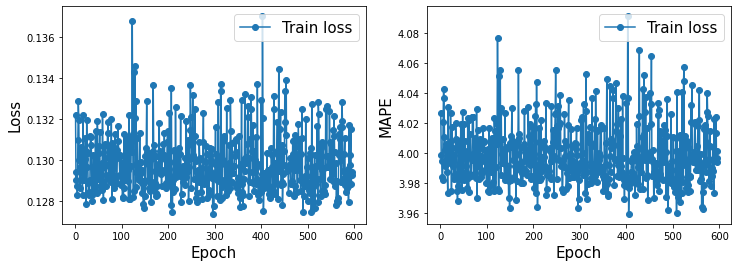

In [141]:
tf.keras.backend.clear_session()
modelParam = modelParams[modelName]
model = modelParam['model']
model.summary()
history = train_model(X, y, model, modelParam)
plot_loss(history)

Load model from f:\Work\Coding\Class\ai-class-2564-1\Topic 07 - ANN\tmp\S6\2021-09-25-09-04-29


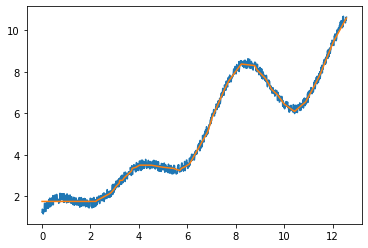

In [142]:
latestDir = get_latest_checkpoint_folder(modelParam['checkpoint_dirname'])
print(f'Load model from {latestDir}')
latestFile = tf.train.latest_checkpoint(latestDir)
model.load_weights(latestFile)
plot_predict(X, y, model)